In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.forest import Forest
from sklearn.ensemble import IsolationForest
from sklearn import mixture
from scipy.linalg import qr
import scipy.stats as scp
from math import cos
from sklearn.neighbors import LocalOutlierFactor
import rrcf
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from sklearn.svm import OneClassSVM
import pandas as pd

In [2]:
def add_dimension(arr, dim):
    if dim == 0:
        return arr
    _, n_pts = np.shape(arr)
    added = np.random.randint(low=0, high = 100, size = ( dim, n_pts))
    added = added - 50
    added = added/25
    return np.vstack((arr,added))
    

In [3]:
#n_pts per Gaussian
def sample_points(n_Gaussians, n_pts, noisy_dim):
    means = []
    covs = []
    for i in range(n_Gaussians):
        #a = np.random.randint(0, 3 * n_Gaussians)
        a = 4*i
        #b = np.random.randint(0, 3 * n_Gaussians)
        b = 4*i
        c = np.random.randint(0, 1000)
        means.append([a,b])
        cov = [[1,cos(c)], [cos(c), 2]]
        #cov = [[0.3 + 3*i,0.1],[0.1,0.1 + 3*i]]
        covs.append(cov)
    G_x = np.zeros((n_Gaussians, n_pts))
    G_y = np.zeros((n_Gaussians, n_pts))
    pts_l = []
    for i in range(n_Gaussians):
        G_x[i], G_y[i] = np.random.multivariate_normal(means[i], covs[i], n_pts).T
        pts_l.append(np.vstack((G_x[i], G_y[i])))    
    pts = np.hstack(pts_l)
    noisy_pts = add_dimension(pts, noisy_dim)
    return pts, noisy_pts, means, covs
    

In [4]:
def get_truth(pts, means, covs):    
    dist = []
    n_G = len(means[0])
    for i in range(n_G):
        dist.append(scp.multivariate_normal(mean = means[i], cov = covs[i]))
    ptsT = np.transpose(pts)
    t_scores = np.zeros(len(ptsT))
    for i in range(len(t_scores)):
        for j in range(n_G):
            t_scores[i] += dist[j].pdf(ptsT[i])
    t_indices = np.argsort(t_scores)[:100]
    return t_indices

In [21]:
def get_iso(noisy_pts):
    rng = np.random.RandomState(27)
    _, n_p = np.shape(noisy_pts)
    clf = IsolationForest(max_samples = 100, random_state = rng, contamination = 0.1, n_estimators= int(n_p / 50), behaviour = "new")
    clf.fit(np.transpose(noisy_pts))
    Y = clf.predict(np.transpose(noisy_pts))
    iso_indices = []
    for i in range(len(Y)):
        if Y[i] == -1:
            iso_indices.append(i)
    return iso_indices

def get_lof(noisy_pts):
    lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
    Z = lof.fit_predict(np.transpose(noisy_pts))
    lof_indices = []
    for i in range(len(Z)):
        if Z[i] == -1:
            lof_indices.append(i)
    return lof_indices

def get_density(noisy_pts):
    _, n_p = np.shape(noisy_pts)
    kwargs = {'max_depth': 12, 'n_trees':20,  'max_samples': 300, 'max_buckets': 3, 'epsilon': 0.1, 'sample_axis': 1, 'threshold': 0}
    forest = Forest(**kwargs)
    forest.fit(noisy_pts)
    gsw_indices, outliers, scores , pst, m_min = forest.predict(noisy_pts, 0.1)
    return gsw_indices

def get_em(noisy_pts, n_g):
    mlf = mixture.GaussianMixture(n_components=n_g, covariance_type='full')
    mlf.fit(np.transpose(noisy_pts))
    Z = -mlf.score_samples(np.transpose(noisy_pts))
    mix_indices = np.argsort(Z)[-100:]
    return mix_indices

def get_rrcf(noisy_pts):
    num_trees = 500
    tree_size = 256
    X = np.transpose(noisy_pts)
    [n,d] = np.shape(X)
    forest = []
    while len(forest) < num_trees:
        # Select random subsets of points uniformly from point set
        ixs = np.random.choice(n, size=(n // tree_size, tree_size),
               replace=False)
        # Add sampled trees to forest
        trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
        forest.extend(trees)
        
    avg_codisp = pd.Series(0.0, index=np.arange(n))
    index = np.zeros(n)
    for tree in forest:
        codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
        avg_codisp[codisp.index] += codisp
        np.add.at(index, codisp.index.values, 1)
    avg_codisp /= index
    alg_scores = avg_codisp
    alg_indices = np.argsort(alg_scores)[-100:]
    return alg_indices

def get_svm(noisy_pts):
    X = np.transpose(noisy_pts)
    clf = OneClassSVM(kernel='rbf')
    clf.fit(X)
    alg_scores = clf.score_samples(X)
    alg_scores = - alg_scores
    alg_indices = np.argsort(alg_scores)[-100:]
    return alg_indices

def get_knn(noisy_pts):
    X = np.transpose(noisy_pts)
    clf = KNN()
    clf.fit(X)
    alg_scores = clf.decision_scores_ 
    alg_indices = np.argsort(alg_scores)[-100:]
    return alg_indices

def get_pca(noisy_pts):
    X = np.transpose(noisy_pts)
    clf = PCA()
    clf.fit(X)
    alg_scores = clf.decision_scores_ 
    alg_indices = np.argsort(alg_scores)[-100:]
    return alg_indices


In [22]:
n_Gaussians = 2
n_pts = 500
n_exp = 1
dimensions = 20
final_res = np.zeros((8, dimensions))
for noisy_dim in range(dimensions):
    print("n_G: ", n_Gaussians, "noisy dim: ", noisy_dim)
    res = np.zeros((8, n_exp))
    for exp in range(n_exp):    
        pts, noisy_pts, means, covs = sample_points(n_Gaussians, n_pts, noisy_dim)
        t_indices = get_truth(pts, means, covs)
        print('IForest ')
        iso_indices = get_iso(noisy_pts)
        print('PIDForest')
        gsw_indices = get_density(noisy_pts)
        print('EM ')
        em_indices = get_em(noisy_pts, n_Gaussians)
        print('LOF ')
        lof_indices = get_lof(noisy_pts)
        print('RRCF ')
        rrcf_indices = get_rrcf(noisy_pts)
        print('SVM ')
        svm_indices = get_svm(noisy_pts)
        print('kNN ')
        knn_indices = get_knn(noisy_pts)
        print('PCA\n')
        pca_indices = get_pca(noisy_pts)
        us = len(set(t_indices).intersection(set(gsw_indices)))
        iso = len(set(t_indices).intersection(set(iso_indices)))
        em = len(set(em_indices).intersection(set(t_indices)))
        lof = len(set(lof_indices).intersection(set(t_indices)))
        rrcf_int = len(set(t_indices).intersection(set(rrcf_indices)))
        svm_int = len(set(t_indices).intersection(set(svm_indices)))
        knn_int = len(set(t_indices).intersection(set(knn_indices)))
        pca_int = len(set(t_indices).intersection(set(pca_indices)))
        
        res[:, exp] = [us, iso, em, lof, rrcf_int, svm_int, knn_int, pca_int]
        print("Exp: ", exp, "Results [us, iso , em, lof, rrcf, svm, knn, pca]", us, iso, em, lof, rrcf_int, svm_int, knn_int, pca_int)
    final_res[:, noisy_dim] = [np.average(res[0,:]), np.average(res[1,:]), np.average(res[2,:]), np.average(res[3,:]), np.average(res[4,:]), np.average(res[5,:]), np.average(res[6,:]), np.average(res[7,:])]
    print("averages for dimension", noisy_dim, ": ", final_res[:,noisy_dim])

n_G:  2 noisy dim:  0
IForest 
PIDForest
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 80 50 93 57 75 85 72 48
averages for dimension 0 :  [80. 50. 93. 57. 75. 85. 72. 48.]
n_G:  2 noisy dim:  1
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 81 46 80 63 74 77 78 41
averages for dimension 1 :  [81. 46. 80. 63. 74. 77. 78. 41.]
n_G:  2 noisy dim:  2
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 70 37 70 68 66 64 68 38
averages for dimension 2 :  [70. 37. 70. 68. 66. 64. 68. 38.]
n_G:  2 noisy dim:  3
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 68 36 63 55 68 59 62 38
averages for dimension 3 :  [68. 36. 63. 55. 68. 59. 62. 38.]
n_G:  2 noisy dim:  4
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 47 22 59 57 54 49 55 24
averages for dimension 4 :  [47. 22. 59. 57. 54. 49. 55. 24.]
n_G:  2 noisy dim:  5
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 52 34 54 50 60 43 53 35
averages for dimension 5 :  [52. 34. 54. 50. 60. 43. 53. 35.]
n_G:  2 noisy dim:  6
IForest 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


PIDForest
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 53 19 47 43 56 40 46 31
averages for dimension 6 :  [53. 19. 47. 43. 56. 40. 46. 31.]
n_G:  2 noisy dim:  7
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


error: var_red is -0.5
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 54 18 50 47 59 45 52 25
averages for dimension 7 :  [54. 18. 50. 47. 59. 45. 52. 25.]
n_G:  2 noisy dim:  8
IForest 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


PIDForest
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 45 18 44 43 45 37 43 31
averages for dimension 8 :  [45. 18. 44. 43. 45. 37. 43. 31.]
n_G:  2 noisy dim:  9
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 47 13 39 33 53 37 37 25
averages for dimension 9 :  [47. 13. 39. 33. 53. 37. 37. 25.]
n_G:  2 noisy dim:  10
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 62 24 51 44 57 46 47 26
averages for dimension 10 :  [62. 24. 51. 44. 57. 46. 47. 26.]
n_G:  2 noisy dim:  11
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 46 14 44 42 48 35 41 18
averages for dimension 11 :  [46. 14. 44. 42. 48. 35. 41. 18.]
n_G:  2 noisy dim:  12
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 60 17 39 31 54 37 35 22
averages for dimension 12 :  [60. 17. 39. 31. 54. 37. 35. 22.]
n_G:  2 noisy dim:  13
IForest 
PIDForest
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 49 13 40 37 49 43 42 27
averages for dimension 13 :  [49. 13. 40. 37. 49. 43. 42. 27.]
n_G:  2 noisy dim:  14
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 56 13 47 39 57 38 40 28
averages for dimension 14 :  [56. 13. 47. 39. 57. 38. 40. 28.]
n_G:  2 noisy dim:  15
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 55 21 35 32 53 38 39 20
averages for dimension 15 :  [55. 21. 35. 32. 53. 38. 39. 20.]
n_G:  2 noisy dim:  16
IForest 
PIDForest


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 44 11 36 41 44 35 42 16
averages for dimension 16 :  [44. 11. 36. 41. 44. 35. 42. 16.]
n_G:  2 noisy dim:  17
IForest 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


PIDForest
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 51 14 35 28 46 41 34 19
averages for dimension 17 :  [51. 14. 35. 28. 46. 41. 34. 19.]
n_G:  2 noisy dim:  18
IForest 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


PIDForest
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 49 9 33 33 46 35 35 19
averages for dimension 18 :  [49.  9. 33. 33. 46. 35. 35. 19.]
n_G:  2 noisy dim:  19
IForest 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


PIDForest
EM 
LOF 
RRCF 
SVM 
kNN 
PCA

Exp:  0 Results [us, iso , em, lof, rrcf, svm, knn, pca] 46 16 35 35 43 35 31 16
averages for dimension 19 :  [46. 16. 35. 35. 43. 35. 31. 16.]


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [23]:
print(final_res)

[[80. 81. 70. 68. 47. 52. 53. 54. 45. 47. 62. 46. 60. 49. 56. 55. 44. 51.
  49. 46.]
 [50. 46. 37. 36. 22. 34. 19. 18. 18. 13. 24. 14. 17. 13. 13. 21. 11. 14.
   9. 16.]
 [93. 80. 70. 63. 59. 54. 47. 50. 44. 39. 51. 44. 39. 40. 47. 35. 36. 35.
  33. 35.]
 [57. 63. 68. 55. 57. 50. 43. 47. 43. 33. 44. 42. 31. 37. 39. 32. 41. 28.
  33. 35.]
 [75. 74. 66. 68. 54. 60. 56. 59. 45. 53. 57. 48. 54. 49. 57. 53. 44. 46.
  46. 43.]
 [85. 77. 64. 59. 49. 43. 40. 45. 37. 37. 46. 35. 37. 43. 38. 38. 35. 41.
  35. 35.]
 [72. 78. 68. 62. 55. 53. 46. 52. 43. 37. 47. 41. 35. 42. 40. 39. 42. 34.
  35. 31.]
 [48. 41. 38. 38. 24. 35. 31. 25. 31. 25. 26. 18. 22. 27. 28. 20. 16. 19.
  19. 16.]]


In [ ]:
np.savetxt('mixture_noise_all.text', final_res)

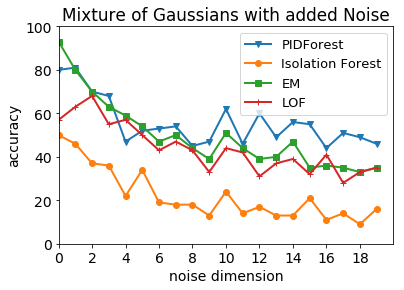

In [24]:
#plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':14})
plt.title('Mixture of Gaussians with added Noise')
plt.plot(final_res[0,:], label = "PIDForest", linewidth = 2, marker = "v")
plt.plot(final_res[1,:], label = "Isolation Forest", linewidth = 2, marker = "o")
plt.plot(final_res[2,:], label = "EM", linewidth = 2, marker = "s")
plt.plot(final_res[3,:], label = "LOF", linewidth = 2, marker = "+")

plt.xticks(np.arange(0, 20, step=2))
plt.legend(prop={'size':13})
plt.ylabel('accuracy')
plt.xlabel('noise dimension')
plt.axis([0, 20, 0, 100])
# plt.savefig("noisy_Gaussian.pdf", bbox_inches = 'tight')
plt.show()

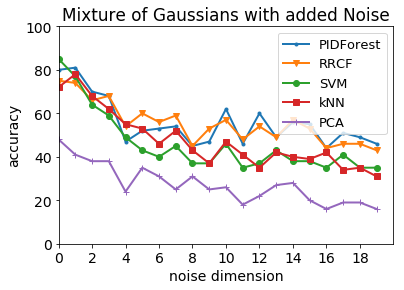

In [27]:
#plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':14})
plt.title('Mixture of Gaussians with added Noise')
plt.plot(final_res[0,:], label = "PIDForest", linewidth = 2, marker = ".")
plt.plot(final_res[4,:], label = "RRCF", linewidth = 2, marker = "v")
plt.plot(final_res[5,:], label = "SVM", linewidth = 2, marker = "o")
plt.plot(final_res[6,:], label = "kNN", linewidth = 2, marker = "s")
plt.plot(final_res[7,:], label = "PCA", linewidth = 2, marker = "+")

plt.xticks(np.arange(0, 20, step=2))
plt.legend(prop={'size':13})
plt.ylabel('accuracy')
plt.xlabel('noise dimension')
plt.axis([0, 20, 0, 100])
plt.savefig("noisy_Gaussian_all.pdf", bbox_inches = 'tight')
plt.show()

In [26]:
final_res

array([[80., 81., 70., 68., 47., 52., 53., 54., 45., 47., 62., 46., 60.,
        49., 56., 55., 44., 51., 49., 46.],
       [50., 46., 37., 36., 22., 34., 19., 18., 18., 13., 24., 14., 17.,
        13., 13., 21., 11., 14.,  9., 16.],
       [93., 80., 70., 63., 59., 54., 47., 50., 44., 39., 51., 44., 39.,
        40., 47., 35., 36., 35., 33., 35.],
       [57., 63., 68., 55., 57., 50., 43., 47., 43., 33., 44., 42., 31.,
        37., 39., 32., 41., 28., 33., 35.],
       [75., 74., 66., 68., 54., 60., 56., 59., 45., 53., 57., 48., 54.,
        49., 57., 53., 44., 46., 46., 43.],
       [85., 77., 64., 59., 49., 43., 40., 45., 37., 37., 46., 35., 37.,
        43., 38., 38., 35., 41., 35., 35.],
       [72., 78., 68., 62., 55., 53., 46., 52., 43., 37., 47., 41., 35.,
        42., 40., 39., 42., 34., 35., 31.],
       [48., 41., 38., 38., 24., 35., 31., 25., 31., 25., 26., 18., 22.,
        27., 28., 20., 16., 19., 19., 16.]])